<a href="https://colab.research.google.com/github/eman-kom/tensorflow-fundamentals/blob/main/06_scaling_up_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
!nvidia-smi

Mon Jun 13 14:17:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    32W /  70W |   4842MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [16]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-06-13 14:17:28--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-06-13 14:17:28 (105 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [17]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In [18]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train"
test_dir = "101_food_classes_10_percent/test"

--2022-06-13 14:17:28--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.31.128, 74.125.141.128, 173.194.210.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.31.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip.1’

101_food_classes_10 100%[===================>]   1.51G  76.5MB/s    in 18s     

2022-06-13 14:17:46 (86.7 MB/s) - ‘101_food_classes_10_percent.zip.1’ saved [1625420029/1625420029]



In [19]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/poutine'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/clam_chowder'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/churros'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/deviled_eggs'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/gyoza'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/club_sandwich'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/tuna_tartare'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/onion_rings'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/crab_cakes'.
There are 0 directories and 75 images in '101_food

In [20]:
import tensorflow as tf

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    image_size=(224, 224)
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    image_size=(224, 224),
    shuffle=False
)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [21]:
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    monitor="val_accuracy",
    save_best_only=True
)

In [22]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2)
], name="data_augmentation")

In [23]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=(224, 224, 3), name="input_layer")

x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)

outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

In [24]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"] 
)

history_all_classes_10_percent = model.fit(
    train_data_all_10_percent,
    epochs=5,
    validation_data=test_data,
    validation_steps=int(0.15 * len(test_data)),
    callbacks=[checkpoint_callback]
)

Epoch 1/5
237/237 [==============================] - 54s 204ms/step - loss: 3.4812 - accuracy: 0.2405 - val_loss: 2.6565 - val_accuracy: 0.4139
Epoch 2/5
237/237 [==============================] - 44s 186ms/step - loss: 2.3626 - accuracy: 0.4570 - val_loss: 2.2300 - val_accuracy: 0.4772
Epoch 3/5
237/237 [==============================] - 42s 177ms/step - loss: 1.9841 - accuracy: 0.5258 - val_loss: 2.0570 - val_accuracy: 0.4989
Epoch 4/5
237/237 [==============================] - 40s 169ms/step - loss: 1.7712 - accuracy: 0.5682 - val_loss: 1.9459 - val_accuracy: 0.5098
Epoch 5/5
237/237 [==============================] - 39s 163ms/step - loss: 1.6090 - accuracy: 0.6088 - val_loss: 1.9139 - val_accuracy: 0.5072


In [25]:
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 60s 75ms/step - loss: 1.7276 - accuracy: 0.5493


[1.7275716066360474, 0.5493069291114807]

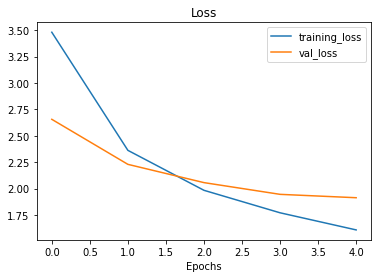

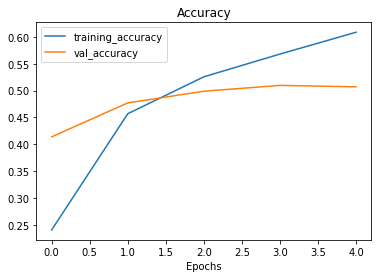

In [26]:
plot_loss_curves(history_all_classes_10_percent)

In [29]:
base_model.trainable = True

for layer in base_model.layers[:-5]:
  layer.trainable = False

model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(0.0001),
    metrics=["accuracy"]
)

In [ ]:
history_all_classes = model.fit(
    train_data_all_10_percent,
    epochs=10,
    validation_data=test_data,
    validation_steps=int(0.15 * len(test_data)),
    initial_epoch=history_all_classes_10_percent.epoch[-1]
)

Epoch 5/10
237/237 [==============================] - 49s 176ms/step - loss: 1.3562 - accuracy: 0.6466 - val_loss: 1.8958 - val_accuracy: 0.5040
Epoch 6/10
237/237 [==============================] - 37s 154ms/step - loss: 1.2438 - accuracy: 0.6696 - val_loss: 1.8669 - val_accuracy: 0.5135
Epoch 7/10
 32/237 [===>..........................] - ETA: 23s - loss: 1.2045 - accuracy: 0.6729

In [ ]:
fine_tuned_results = model.evaluate(test_data)
fine_tuned_results

In [ ]:
compare_historys(history_all_classes_10_percent, fine_tuned_results)